<a href="https://colab.research.google.com/github/ochekroun/projet-ia/blob/master/classification-images/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !python -V

In [ ]:
#!pip install -r requirements.txt

In [ ]:
# !pip install tensorflow==2.16.2
# !pip install keras==3.4.1

In [ ]:
# utilisons pytorch plutôt que tensorflow
# import os
# os.environ["KERAS_BACKEND"] = "torch"

In [ ]:
import keras
from keras import layers
from keras.applications import EfficientNetB0
import requests
import tarfile
import os
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
import json
from torch.utils.data import Dataset
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [ ]:
#!rm -rf ./data/nuswide_81/


In [ ]:
%%time
download_file = False

from pathlib import Path
Path("./data").mkdir(parents=True, exist_ok=True)

if download_file:
    def decompress(tar_file, file_path, members=None):
        """
        Extracts `tar_file` and puts the `members` to `path`.
        If members is None, all members on `tar_file` will be extracted.
        """
        tar = tarfile.open(tar_file, mode="r:gz")
        if members is None:
            members = tar.getmembers()
        # with progress bar
        # set the progress bar
        progress = tqdm(members)
        for member in progress:
            tar.extract(member, path=file_path)
            # set the progress description of the progress bar
            progress.set_description(f"Extracting {member.name}")

        tar.close()

    def download(url, file_path):
        # Streaming, so we can iterate over the response.
        response = requests.get(url, stream=True)

        # Sizes in bytes.
        total_size = int(response.headers.get("content-length", 0))
        block_size = 4096

        with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
            with open(file_path, "wb") as file:
                for data in response.iter_content(block_size):
                    progress_bar.update(len(data))
                    file.write(data)

        if total_size != 0 and progress_bar.n != total_size:
            raise RuntimeError("Could not download file")


    download('https://olivierchekroun.blob.core.windows.net/documents/projet-ia/nus_wide.tar.gz','./data/nus_wide.tar.gz')
    decompress('./data/nus_wide.tar.gz', './data/nuswide_81')
    
    download('https://olivierchekroun.blob.core.windows.net/documents/projet-ia/data.tar.gz','./data/data.tar.gz')
    decompress('./data/data.tar.gz', './data/')



check_image_file = False
if check_image_file:
    image_dir = './data/images'
    bad_image_file_path = './data/bad_images.txt'
    IMG_SIZE = 224
    size = (IMG_SIZE, IMG_SIZE)
    count = 0
    try:
        os.remove(bad_image_file_path)
    except OSError:
        pass
    arr = os.listdir(image_dir)
    print(len(arr))
    bad_files = []
    for image_name in tqdm(arr):
        count += 1
        imagePath = os.path.join(image_dir, image_name)
        try:
            image = Image.open(imagePath)
            image.load()
            image = tf.image.resize(image, size)
            image = image.numpy()
        except Exception as e:
            print(f'{e} {imagePath}')
            bad_files.append(image_name)
            continue
    print(f'Images count: {count}')

    print(bad_files)

    with open(bad_image_file_path, 'w') as f:
        for line in bad_files:
            f.write(f"{line}\n")

In [ ]:
def load_labels():
    labels = []
    with open('./data/labels.txt') as f:
        lines = f.read().splitlines()
        for line in lines:
            labels.append(line)
    return labels

def load_dataframe(file_name):
    with open('./data/bad_images.txt', 'r') as file:
        bad_files = file.read().splitlines()

    print(f'Bad files {bad_files}')

    labels = load_labels()

    # Étape 1 : Charger la liste des images

    with open(file_name) as f:
        all_samples_data = f.read().splitlines()

    image_names =[]
    # string_values = []
    # array_values = []
    given_labels = []
    for data_line in tqdm(all_samples_data):
        parts = data_line.split(' ')
        image_name = parts[0]
        array_value = np.asarray(list(map(int, parts[1:])))
        #string_value = ' '.join(parts[1:])

        given_label = np.array(labels)[np.argwhere(array_value)[:, 0]]
        #print(given_labels)

        image_names.append(image_name)
        # string_values.append(string_value)
        # array_values.append(array_value)
        given_labels.append(given_label)

    # Étape 3 : Créer le DataFrame
    data = {'image': image_names, 'labels': given_labels}
    df = pd.DataFrame(data)
    print(f'Dataframe length: {len(df)}')

    # Étape 4 : Exclure les lignes où il n'y a que des 0 dans les tableaux de valeurs
    df_filtered = df
    df_filtered = df[df['labels'].apply(lambda x: any(x))]
    df_filtered = df_filtered[~df_filtered['image'].isin(bad_files)]
    # if stratify :
    #     df_filtered = df_filtered.groupby('String_Values').filter(lambda x: len(x) > 1)
    print(f'Dataframe filtered length: {len(df_filtered)}')

    return df_filtered

In [ ]:
df = load_dataframe('./data/database.txt')

In [ ]:
label_freq = df['labels'].apply(lambda x: x).explode().value_counts().sort_values(ascending=False)
# Create a list of rare labels
rare = list(label_freq[label_freq<1000].index)

#rare = []

print("We will be ignoring these rare labels:", rare)
labels = load_labels()
keep = [x for x in labels if x not in rare ]
print(keep)

print(len(rare))
print(len(keep))

In [ ]:
df['labels'] = df['labels'].apply(lambda x: [tag for tag in x if tag not in rare])
label_freq2 = df['labels'].apply(lambda x: x).explode().value_counts().sort_values(ascending=False)
flatten = [item for sublist in df['labels'] for item in sublist]
distinct = set(flatten)
distinct_list = list(distinct)
print(distinct_list)
print(len(distinct_list))

print(len(df))
df = df[df['labels'].apply(lambda x: any(x))]
print(len(df))

In [ ]:
df['stratify_label'] = df['labels'].apply(lambda x: '|'.join(x))
labels_count = df['stratify_label'].value_counts()
valid_labels = labels_count[labels_count >= 20].index
df_filtered = df[df['stratify_label'].isin(valid_labels)]
print(len(df))
print(len(df_filtered))


In [ ]:
def custom_train_test_split(df, stratify_column, train_samples):
    # Create initial train set of fixed number of samples
    X_train, X_temp = train_test_split(
        df, train_size=train_samples, stratify=df[stratify_column], random_state=42
    )
    
    # Calculate the size of validation set (0.2% of train size)
    val_size = int(0.1 * train_samples)
    
    # Create the validation set from the remaining data
    X_val, X_temp,  = train_test_split(
        X_temp, test_size=(len(X_temp) - val_size), stratify=X_temp[stratify_column], random_state=42
    )
    
    # Calculate the size of test set (50% of validation size)
    #test_size = int(0.5 * val_size)
    test_size = val_size
    
    # Create the test set from the remaining data
    X_test, X_unused = train_test_split(
        X_temp, test_size=(len(X_temp) - test_size), stratify=X_temp[stratify_column], random_state=42
    )
    
    return X_train, X_val, X_test


In [ ]:
# Example usage:
# X, y are your features and target DataFrame respectively
# stratify_column is the name of the column in y used for stratification
# train_samples is the fixed number of samples for the train set

X_train, X_val, X_test = custom_train_test_split(df_filtered, 'stratify_label', 10000)

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

In [ ]:
# # Step 6: Perform the first split to create training and test sets with stratification
# train_size = 20000
# val_size = int(train_size * 0.2)
# train_df, val_df = train_test_split(
#         df_filtered,
#         stratify = df_filtered['stratify_label'].values,
#         train_size = train_size,
#         test_size= 0.2
#         )


In [ ]:
# test_size = int(val_size / 2)
# train_df, test_df = train_test_split(
#         val_df,
#         stratify = val_df['stratify_label'].values,
#         test_size= 0.5
#         )

In [ ]:
# %%time
# stratify = False
# num_class = df['String_Values'].nunique()
# print(num_class)
# train_size = 10000
# val_size = num_class if stratify else int(train_size * 0.2)
# test_size = val_size

# if stratify:
#     train_df, val_df = train_test_split(
#         df,
#         stratify = df['String_Values'].values,
#         train_size = train_size,
#         test_size= val_size
#         )
# else:
#     train_df, val_df = train_test_split(
#         df,
#         train_size = train_size,
#         test_size= val_size
#         )

#     train_df, test_df = train_test_split(
#         train_df,
#         test_size = test_size
#     )

# print("Number of images for training: ", len(train_df))
# print("Number of images for validation: ", len(val_df))
# print("Number of images for test: ", len(test_df))



# df = load_dataframe('./data/nuswide_81/test.txt')
# num_class = df['String_Values'].nunique()
# print(num_class)
# val_size = num_class if stratify else int(train_size * 0.2)
# if stratify:
#     test_df, _ = train_test_split(
#         df,
#         stratify = df['String_Values'].values,
#         train_size=val_size
#         )
# else:
#     test_df, _ = train_test_split(
#     df,
#     train_size=val_size,
# )
# print("Number of images for test: ", len(test_df))

In [ ]:
def write_df(df, labels, file_path):
    rows = []
    for index, row in df[['image', 'labels']].iterrows():
        row_image = row['image']
        row_labels = row['labels']
        row = {'image_name': row_image, 'image_labels': row_labels}
        rows.append(row)
    with open(file_path, 'w') as fp:
        json.dump({'samples': rows, 'labels': labels}, fp, indent=3)

# write_df(train_df, labels, './data/train.json')
# write_df(val_df, labels, './data/val.json')
# write_df(test_df, labels, './data/test.json')

write_df(X_train, keep, './data/train.json')
write_df(X_val, keep, './data/val.json')
write_df(X_test, keep, './data/test.json')

In [ ]:
class NusDataset(Dataset):
    def __init__(self, anno_path):
        with open(anno_path) as fp:
            json_data = json.load(fp)
        samples = json_data['samples']
        self.classes = json_data['labels']

        self.imgs = []
        self.annos = []
        self.labels = []
        print('loading', anno_path)
        for sample in samples:
            self.imgs.append(sample['image_name'])
            labels = sample['image_labels']
            self.labels.append(labels)

            vector = [cls in labels for cls in self.classes]
            self.annos.append(np.array(vector, dtype=float))

            
        # for item_id in range(len(self.annos)):
        #     item = self.annos[item_id]
        #     vector = [cls in item for cls in self.classes]
        #     self.annos[item_id] = np.array(vector, dtype=float)

    def __getitem__(self, idx):
        anno = self.annos[idx]
        try:
            img_path = self.imgs[idx]
            image = Image.open(img_path)
            image = image_processing(image)            
        except Exception as e:
            print(f'{e} {img_path}')
        return image, anno

    def __len__(self):
        return len(self.imgs)
    
    def num_classes(self):
        return len(self.classes)
    
    def image_labels(self, idx):
        #anno = self.annos[idx]
        #img_labels = np.array(self.classes)[np.argwhere(anno > 0)[:, 0]]
        img_labels = self.labels[idx]
        img_path = self.imgs[idx]
        image = Image.open(img_path)
        return image, img_labels
    
    def predictions(self, k, threshold, image, model):
        # Assurez-vous que l'image est correctement chargée et traitée
        test_img = image_processing(image)  # Correction: Utiliser image_path au lieu de image
        test_img = np.expand_dims(test_img, axis=0)
        
        # Obtenir les prédictions brutes du modèle
        raw_pred = model(test_img, training=False).cpu().numpy()[0]
        
        # Obtenir les indices des k meilleures prédictions
        top_indices = np.argsort(raw_pred)[-k:][::-1]
        
        # Obtenir les étiquettes prédites pour les k meilleures prédictions
        topk_labels = np.array(self.classes)[top_indices]
        
        # Afficher le nombre d'étiquettes prédites (devrait être k)
        print(len(topk_labels))
        
        # Appliquer le seuil pour obtenir les indices des prédictions qui dépassent le seuil
        threshold_indices = raw_pred > threshold
        threshold_labels = np.array(self.classes)[np.where(threshold_indices)]
        
        # Afficher le nombre d'étiquettes qui dépassent le seuil
        print(len(threshold_labels))


        all_labels = set(topk_labels) | set(threshold_labels)

        # Si aucune étiquette n'est prédite (très improbable avec les k meilleures prédictions), définir comme 'aucune prédiction'
        if len(topk_labels) == 0:
            topk_labels = ['No top k predictions']

        # Si aucune étiquette ne dépasse le seuil, définir comme 'aucune prédiction'
        if len(threshold_labels) == 0:
            threshold_labels = ['No threshold predictions']
            
        return topk_labels, threshold_labels, all_labels

def image_processing(image):
    IMG_SIZE = 224
    size = (IMG_SIZE, IMG_SIZE)    
    image = tf.image.resize(image, size)
    image = image.numpy()
    return image

In [ ]:
#!ls ./data/nuswide_81/images/11781_1590858672_d446580056_m.jpg

In [ ]:
# Let's take a look at the data we have. To do it we need to load the dataset without augmentations.
samples_ds = NusDataset('./data/test.json')

for idx in range(5):
    img, labels = samples_ds.image_labels(idx)
    plt.imshow(img)
    plt.title("{}".format(', '.join(labels)))
    plt.axis('off')
    plt.show()

In [ ]:
def show_histo(dataset_val,):
    with np.printoptions(precision=3, suppress=True):
        samples = dataset_val.annos
        samples = np.array(samples)
        class_counts = np.sum(samples, axis=0)
        # Sort labels according to their frequency in the dataset.
        sorted_ids = np.array([i[0] for i in sorted(enumerate(class_counts), key=lambda x: x[1])], dtype=int)
        print('Label distribution (count, class name):', list(zip(class_counts[sorted_ids].astype(int), np.array(dataset_val.classes)[sorted_ids])))
        plt.figure(figsize=(12,20))
        plt.barh(range(len(dataset_val.classes)), width=class_counts[sorted_ids])
        plt.yticks(range(len(dataset_val.classes)), np.array(dataset_val.classes)[sorted_ids])
        plt.gca().margins(y=0)
        plt.grid()
        plt.title('Label distribution')
        plt.show()

show_histo(samples_ds)

In [ ]:
train_ds = NusDataset('./data/train.json')
val_ds = NusDataset('./data/val.json')
test_ds = NusDataset('./data/test.json')

# show_histo(train_ds)
# show_histo(val_ds)
# show_histo(test_ds)

batch_size = 32
num_workers = 8
num_classes = len(train_ds.classes)

train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))

    # On retire les dernières couches avec "include_top=False"
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # "Glace" the paramètres pré-entrainés
    model.trainable = False

    # On rajoute les couches retirées - ces couches sont entrainables !
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)

    # On peut ajuster le ratio de neurones désactivés pour la couche Dropout
    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation='sigmoid', name="predictions")(x)

    # Compile le nouveau modèle
    model = keras.Model(inputs, outputs, name="EfficientNet")

    # On augmente le learning rate du défaut 0.001 à 0.01
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(
         optimizer=optimizer,
         loss=tf.keras.metrics.binary_crossentropy,
         metrics=["binary_accuracy"]
    )
    return model

In [ ]:
print(len(train_ds.classes))
model = build_model(len(train_ds.classes))

In [ ]:
unfreeze = False
def unfreeze_model(model):
    # On rends entrainable les derniers 20 layers (sauf ceux de BatchNormalization)
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
          layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss=tf.keras.metrics.binary_crossentropy, metrics=["binary_accuracy"]
    )


if unfreeze:
    unfreeze_model(model)

In [ ]:
#!pip list| grep keras

In [28]:
history = model.fit(x=train_dl,validation_data=val_dl,epochs=3)
model.save('simple_model_without_unfreeze.keras')

312/312 ━━━━━━━━━━━━━━━━━━━━ 210s 667ms/step - binary_accuracy: 0.9717 - loss: 0.0988 - val_binary_accuracy: 0.9786 - val_loss: 0.0751
Epoch 3/3
312/312 ━━━━━━━━━━━━━━━━━━━━ 206s 651ms/step - binary_accuracy: 0.9755 - loss: 0.0826 - val_binary_accuracy: 0.9790 - val_loss: 0.0690


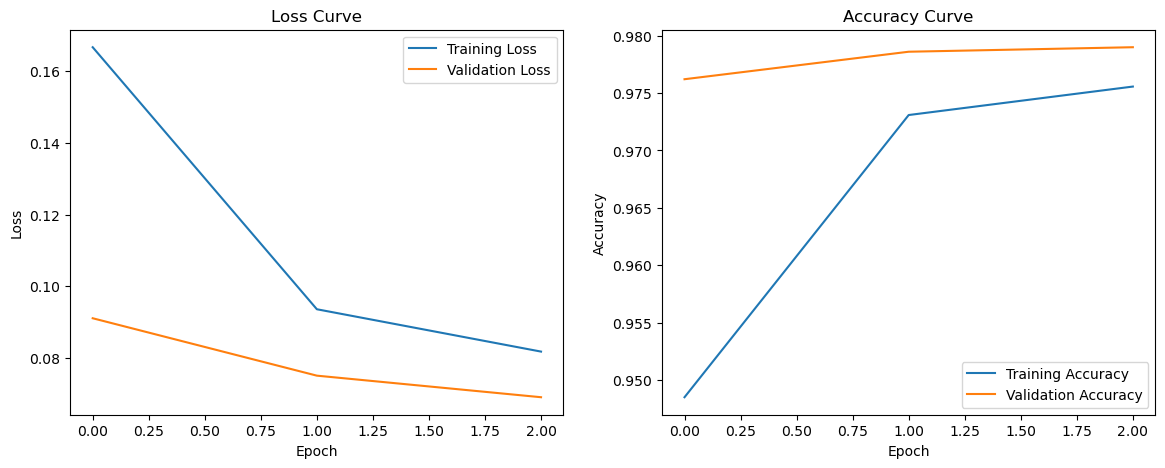

In [29]:
# Retrieve data from the history
loss = history.history['loss']
val_loss = history.history['val_loss']
binary_accuracy = history.history['binary_accuracy']
val_binary_accuracy = history.history['val_binary_accuracy']

# Plot the loss curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(binary_accuracy, label='Training Accuracy')
plt.plot(val_binary_accuracy, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [30]:
model = keras.saving.load_model('simple_model_without_unfreeze.keras')
model.evaluate(x=test_dl)

32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 529ms/step - binary_accuracy: 0.9677 - loss: 0.1159


[0.11496929824352264, 0.9670392870903015]

In [31]:
# # Run inference on the test data
# samples_ds = NusDataset('./data/test.json', image_processing)
# for sample_id in range(200, 250):
#     test_img, test_labels = samples_ds[sample_id]
#     test_img_path = samples_ds.imgs[sample_id]
#     test_img = np.expand_dims(test_img, axis=0)
#     # raw_pred  = model(test_img, training = False)[0]
#     raw_pred = model(test_img, training = False).cpu()[0]
#     raw_pred = np.array(raw_pred > 0.5, dtype=float)

#     predicted_labels = np.array(samples_ds.classes)[np.argwhere(raw_pred > 0)[:, 0]]
#     print(len(predicted_labels))
#     if not len(predicted_labels):
#         predicted_labels = ['no predictions']
#     img_labels = np.array(samples_ds.classes)[np.argwhere(test_labels > 0)[:, 0]]
#     plt.imshow(Image.open(test_img_path))
#     plt.title("Predicted labels: {} \nGT labels: {}".format(', '.join(predicted_labels), ', '.join(img_labels)))
#     plt.axis('off')
#     plt.show()

In [32]:
def plot_predictions(topk_predictions, treshold_predictions, image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()



In [33]:
samples_ds = NusDataset('./data/test.json')
model = keras.saving.load_model('simple_model_without_unfreeze.keras')

loading ./data/test.json


Instructions for updating:
Use tf.identity with explicit device placement instead.
3
2
['sky' 'clouds' 'ocean']
['clouds' 'sky']
{'sky', 'clouds', 'ocean'}
['clouds', 'lake', 'sky', 'water']


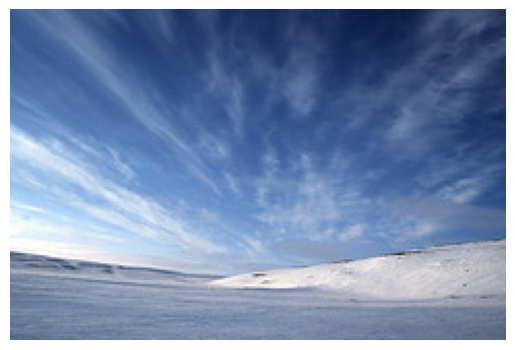

3
2
['horses' 'animal' 'sky']
['animal' 'horses']
{'animal', 'horses', 'sky'}
['animal', 'horses', 'sky']


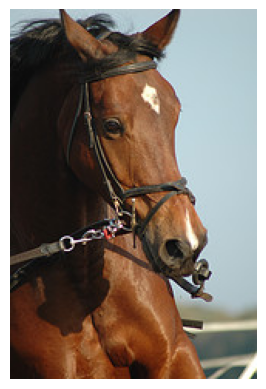

3
0
['animal' 'person' 'clouds']
['No threshold predictions']
{'clouds', 'person', 'animal'}
['road']


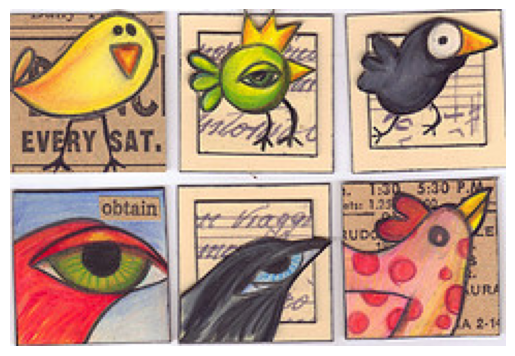

3
0
['sky' 'window' 'clouds']
['No threshold predictions']
{'window', 'clouds', 'sky'}
['sky']


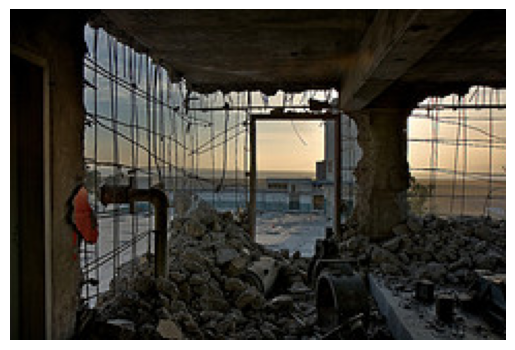

3
21
['military' 'house' 'sunset']
['bear' 'birds' 'boats' 'buildings' 'cars' 'cityscape' 'dog' 'fish'
 'garden' 'grass' 'horses' 'house' 'lake' 'military' 'mountain' 'plane'
 'police' 'sign' 'sunset' 'vehicle' 'window']
{'sunset', 'cars', 'boats', 'fish', 'mountain', 'bear', 'police', 'dog', 'cityscape', 'house', 'vehicle', 'grass', 'window', 'sign', 'plane', 'lake', 'garden', 'horses', 'buildings', 'birds', 'military'}
['military']


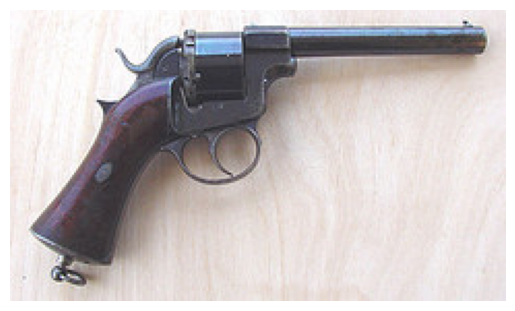

3
2
['sky' 'clouds' 'grass']
['clouds' 'sky']
{'clouds', 'sky', 'grass'}
['sun']


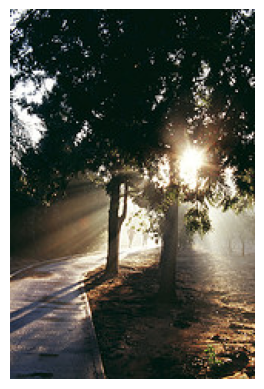

3
3
['rocks' 'sky' 'water']
['rocks' 'sky' 'water']
{'rocks', 'sky', 'water'}
['sky', 'water']


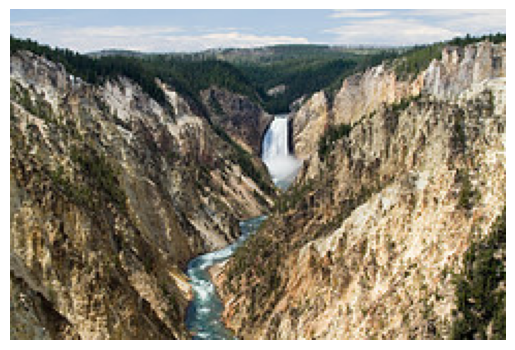

3
2
['animal' 'grass' 'dog']
['animal' 'grass']
{'animal', 'dog', 'grass'}
['animal']


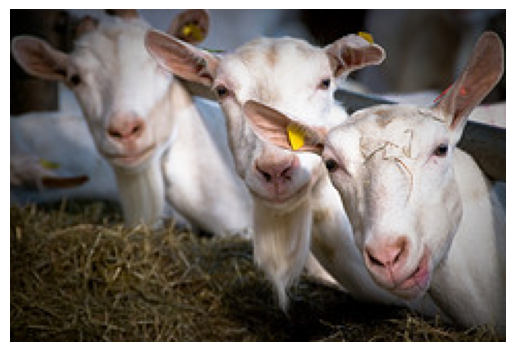

3
1
['person' 'animal' 'sky']
['person']
{'person', 'animal', 'sky'}
['person']


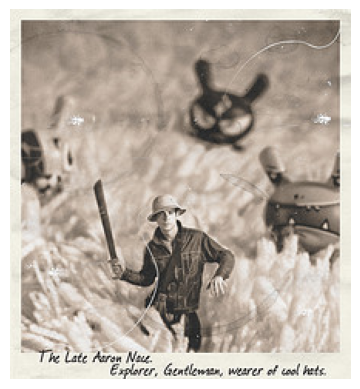

3
3
['water' 'sky' 'clouds']
['clouds' 'sky' 'water']
{'clouds', 'sky', 'water'}
['water']


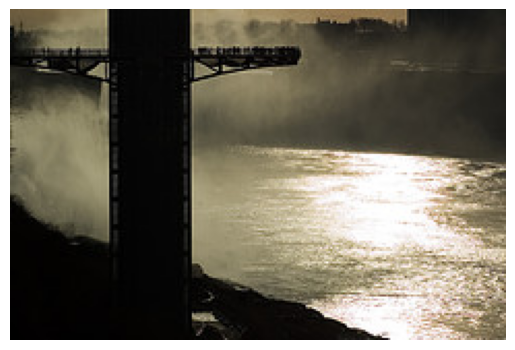

In [34]:

for idx in range(205, 215):
    image, labels = samples_ds.image_labels(idx)
    topk, treshold, all = samples_ds.predictions(3, 0.5, image, model)
    print(topk)
    print(treshold)
    print(all)
    print(labels)
    plot_predictions([], [], image)

USA (138).JPG
3
1
['sky' 'clouds' 'rocks']
['sky']
{'clouds', 'sky', 'rocks'}


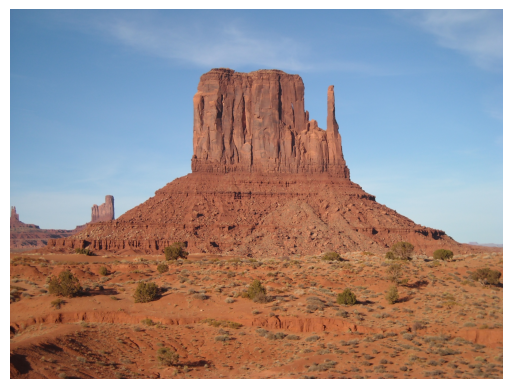

DSCN9015.JPG
3
1
['sky' 'clouds' 'rocks']
['sky']
{'clouds', 'sky', 'rocks'}


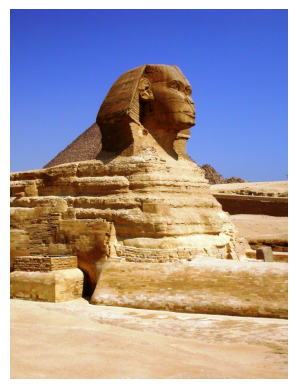

DSC03484.JPG
3
1
['sky' 'clouds' 'buildings']
['sky']
{'clouds', 'buildings', 'sky'}


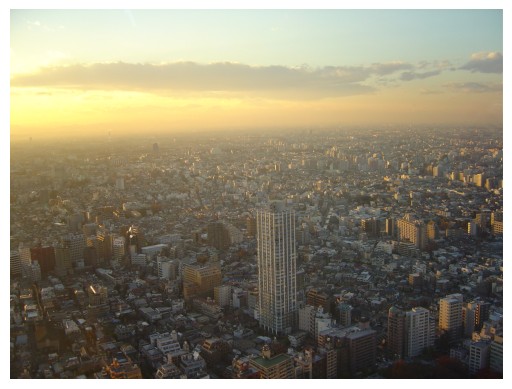

Argentina (375).JPG
3
1
['water' 'sky' 'clouds']
['water']
{'clouds', 'sky', 'water'}


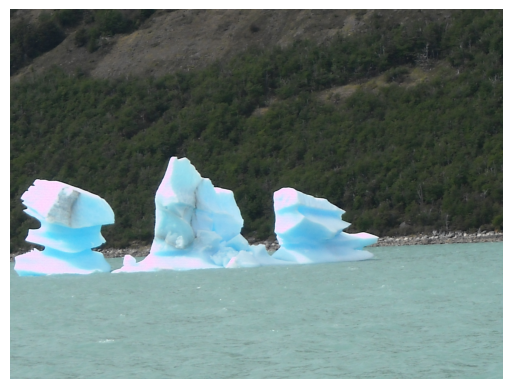

Argentina (449).JPG
3
4
['water' 'sky' 'lake']
['clouds' 'lake' 'sky' 'water']
{'lake', 'clouds', 'sky', 'water'}


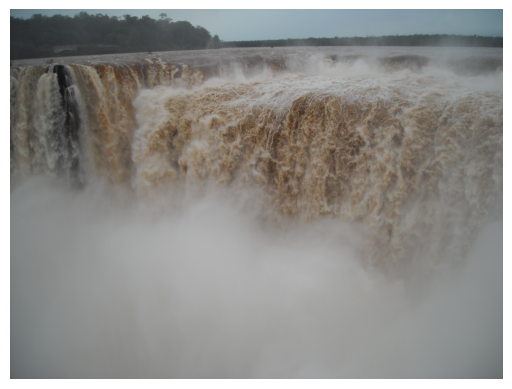

DSCN0870.JPG
3
2
['sky' 'clouds' 'water']
['clouds' 'sky']
{'clouds', 'sky', 'water'}


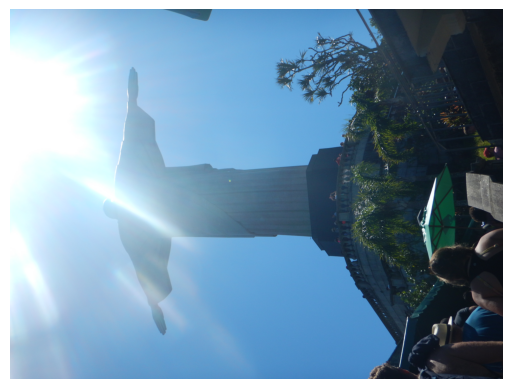

Petra (59).JPG
3
1
['window' 'buildings' 'sky']
['window']
{'window', 'buildings', 'sky'}


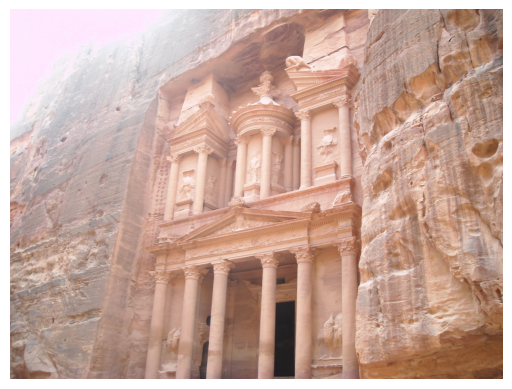

DSCN1275_Moment.jpg
3
4
['water' 'coral' 'ocean']
['animal' 'coral' 'ocean' 'water']
{'animal', 'coral', 'ocean', 'water'}


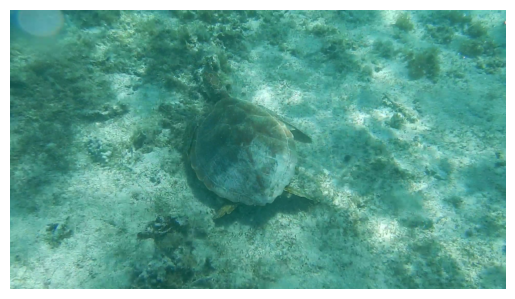

DSCN0968.JPG
3
2
['water' 'sky' 'clouds']
['sky' 'water']
{'clouds', 'sky', 'water'}


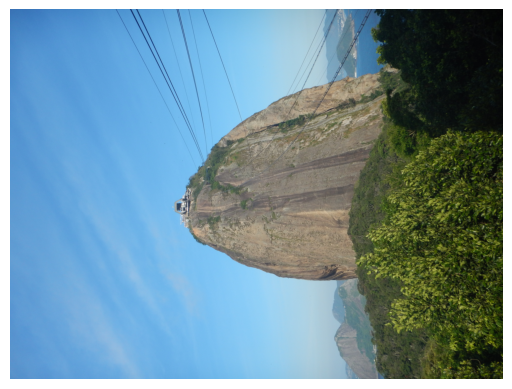

DSCN1116.JPG
3
1
['rocks' 'water' 'sky']
['rocks']
{'water', 'sky', 'rocks'}


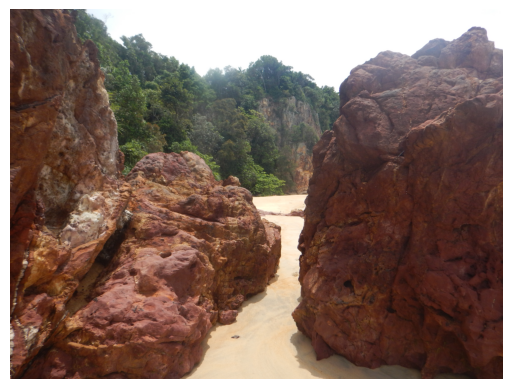

In [35]:
import os
from keras.preprocessing import image as ximage

directory_path = './data/images_persos'

# List all files and directories
for entry in os.listdir(directory_path):
    full_path = os.path.join(directory_path, entry)
    if os.path.isfile(full_path):
        print(entry)
        image = Image.open(full_path)
        topk, treshold, all = samples_ds.predictions(3, 0.5, image, model)
        print(topk)
        print(treshold)
        print(all)
        plot_predictions([], [], image)

        continue
        
        image = Image.open(full_path)
        test_img = image_processing(image)
        test_img = np.expand_dims(test_img, axis=0)
        raw_pred = model(test_img, training = False).cpu()[0]
        # raw_pred = np.array(raw_pred > 0.1, dtype=float)
        # predicted_labels = np.array(samples_ds.classes)[np.argwhere(raw_pred > 0)[:, 0]]
        # print(len(predicted_labels))
        # if not len(predicted_labels):
        #     predicted_labels = ['no predictions']

        raw_pred = raw_pred.detach().numpy()
        # Convert the raw predictions to a numpy array
        raw_pred = np.array(raw_pred)

        # Get the indices of the top 3 predictions
        top_3_indices = np.argsort(raw_pred)[-3:][::-1]

        # Get the predicted labels for the top 3 indices
        predicted_labels = np.array(samples_ds.classes)[top_3_indices]

        # Print the number of predicted labels (which should be 3)
        print(len(predicted_labels))

        # If no labels are predicted (highly unlikely with top 3 prediction), set to 'no predictions'
        if not len(predicted_labels):
            predicted_labels = ['no predictions']

        plt.title("Predicted labels: {}".format(', '.join(predicted_labels)))
        plt.imshow(image)
        plt.axis('off')
        plt.show()